<a href="https://colab.research.google.com/github/Winkielek/gflownet/blob/trajectories-analysis/notebooks/trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone gflownet lib
!rm -rf gflownet
!git clone https://github.com/Winkielek/gflownet.git

# Install torch geometric
!pip install torch-geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

# Install gflownet lib
!pip install -e ./gflownet

  Attempting uninstall: gflownet
    Found existing installation: gflownet 0.1.0
    Uninstalling gflownet-0.1.0:
      Successfully uninstalled gflownet-0.1.0


In [1]:
import os
import shutil
import socket
from typing import Callable, Dict, List, Tuple, Union

import numpy as np
import torch
import torch.nn as nn
import torch_geometric.data as gd
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor
from torch.utils.data import Dataset

from gflownet.config import Config
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext, Graph
from gflownet.models import bengio2021flow
from gflownet.online_trainer import StandardOnlineTrainer
from gflownet.trainer import FlatRewards, GFNTask, RewardScalar
from gflownet.utils.conditioning import TemperatureConditional

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
class SEHTask(GFNTask):
    """Sets up a task where the reward is computed using a proxy for the binding energy of a molecule to
    Soluble Epoxide Hydrolases.

    The proxy is pretrained, and obtained from the original GFlowNet paper, see `gflownet.models.bengio2021flow`.

    This setup essentially reproduces the results of the Trajectory Balance paper when using the TB
    objective, or of the original paper when using Flow Matching.
    """

    def __init__(
        self,
        dataset: Dataset,
        cfg: Config,
        rng: np.random.Generator = None,
        wrap_model: Callable[[nn.Module], nn.Module] = None,
    ):
        self._wrap_model = wrap_model
        self.rng = rng
        self.models = self._load_task_models()
        self.dataset = dataset
        self.temperature_conditional = TemperatureConditional(cfg, rng)
        self.num_cond_dim = self.temperature_conditional.encoding_size()

    def flat_reward_transform(self, y: Union[float, Tensor]) -> FlatRewards:
        return FlatRewards(torch.as_tensor(y) / 8)

    def inverse_flat_reward_transform(self, rp):
        return rp * 8

    def _load_task_models(self):
        model = bengio2021flow.load_original_model()
        model, self.device = self._wrap_model(model, send_to_device=True)
        return {"seh": model}

    def sample_conditional_information(self, n: int, train_it: int) -> Dict[str, Tensor]:
        return self.temperature_conditional.sample(n)

    def cond_info_to_logreward(self, cond_info: Dict[str, Tensor], flat_reward: FlatRewards) -> RewardScalar:
        return RewardScalar(self.temperature_conditional.transform(cond_info, flat_reward))

    def compute_flat_rewards(self, mols: List[RDMol]) -> Tuple[FlatRewards, Tensor]:
        graphs = [bengio2021flow.mol2graph(i) for i in mols]
        is_valid = torch.tensor([i is not None for i in graphs]).bool()
        if not is_valid.any():
            return FlatRewards(torch.zeros((0, 1))), is_valid
        batch = gd.Batch.from_data_list([i for i in graphs if i is not None])
        batch.to(self.device)
        preds = self.models["seh"](batch).reshape((-1,)).data.cpu()
        preds[preds.isnan()] = 0
        preds = self.flat_reward_transform(preds).clip(1e-4, 100).reshape((-1, 1))
        return FlatRewards(preds), is_valid


SOME_MOLS = [
    "O=C(NCc1cc(CCc2cccc(N3CCC(c4cc(-c5cc(-c6cncnc6)[nH]n5)ccn4)CC3)c2)ccn1)c1cccc2ccccc12",
    "O=c1nc2[nH]c3cc(-c4cc(C5CC(c6ccc(CNC7CCOC7c7csc(C8=CC(c9ccc%10ccccc%10c9)CCC8)n7)cc6)CO5)c[nH]4)ccc3nc-2c(=O)[nH]1",
    "c1ccc(-c2cnn(-c3cc(-c4cc(CCc5cc(C6CCC(c7cc(-c8ccccc8)[nH]n7)CO6)ncn5)n[nH]4)ccn3)c2)cc1",
    "O=C(NCc1cc(C2CCNC2C2CCNC2)ncn1)c1cccc(-c2cccc(-c3cccc(C4CCC(c5ccccc5)CO4)c3)c2)c1",
    "O=C(NCc1cccc(C2COC(c3ccc4nc5c(=O)[nH]c(=O)nc-5[nH]c4c3)C2)c1)c1cccc(CCc2cccc(-c3ncnc4c3ncn4C3CCCN3)c2)c1",
    "O=C(NCc1ccc(OCc2ccc(-c3ccncc3C3CCNCC3)cn2)cc1)c1cccc(N2CCC(C3CCCN3)CC2)n1",
    "O=C(NCc1ccc(C2CCC(c3cccc(-c4cccc(C5CCOC5)c4)c3)CO2)cn1)c1ccc(-n2ccc(-c3ccc4nc5c(=O)[nH]c(=O)nc-5[nH]c4c3)n2)cn1",
    "O=C(NCc1nc2c(c(=O)[nH]1)NC(c1cn(N3CCN(c4ccc5nc6c(=O)[nH]c(=O)nc-6[nH]c5c4)CC3)c(=O)[nH]c1=O)CN2)c1ccc[n+](-c2cccc(-c3nccc(-c4ccccc4)n3)c2)c1",
    "C1=C(C2CCC(c3ccnc(-c4ccc(CNC5CCC(c6ccncc6)OC5)cc4)n3)CO2)CCC(c2cc(-c3cncnc3)c3ccccc3c2)C1",
    "O=C(NCc1cccc(-c2nccc(-c3cc(-c4ccc5ccccc5c4)n[nH]3)n2)c1)C1CCC(C2CCC(c3cn(-c4ccc5nc6c(=O)[nH]c(=O)nc-6[nH]c5c4)c(=O)[nH]c3=O)OC2)O1",
    "O=C(Nc1ccc2ccccc2c1)c1cccc(-c2cccc(CNN3CCN(C4CCCC(c5cccc(C6CCCN6)c5)C4)CC3)c2)c1",
    "O=C(NCC1CC=C(c2cc(CCc3c[nH]c(-c4cccc(-c5ccccc5)c4)c3)n[nH]2)CC1)c1cccc(C2CCNC2)n1",
    "O=C(Nc1nccc(CNc2cc(C3CCNC3)n[nH]2)n1)c1nccc(C2CCC(C3CCNCC3c3ccc4ccccc4c3)CO2)n1",
    "C1=C(C2CCC(c3ccc(-c4cc(C5CCCNC5)n[nH]4)cc3)OC2)CCCC1CCc1cccc(-c2cccc(-c3ncnc4[nH]cnc34)c2)n1",
    "O=C(NCc1cc(C2CCC(C3CCN(c4cc(-c5nccc(-c6cccc(-c7ccccc7)c6)n5)c[nH]4)CC3)CO2)ccn1)c1ccccc1",
    "O=C(NCc1cccc(-c2ccn(NCc3ccc(-c4cc(C5CNC(c6ccncc6)C5)c[nH]4)cc3)n2)c1)c1ccc2ccccc2c1",
    "O=c1nc2n(-c3cccc(OCc4cccc(CNC5CCC(c6cccc(-c7ccc(C8CCNC8)cc7)c6)OC5)c4)n3)c3ccccc3nc-2c(=O)[nH]1",
    "O=C(NCc1ccc(C2OCCC2C2CC(c3ccnc(-c4ccc5ccccc5c4)c3)CO2)cc1)c1nccc(N2C=CCC(c3ccccc3)=C2)n1",
    "O=C(NCNC(=O)c1cccc(C(=O)NCc2cccc(-c3ccc4[nH]c5nc(=O)[nH]c(=O)c-5nc4c3)c2)n1)c1ccnc(-c2nccc(C3CCCN3)n2)c1",
    "O=c1nc2[nH]c3cc(C4CCC(c5ccc(-c6cc(C7CCC(C8CCCC(C9CCC(c%10ccc(-c%11cncnc%11)cc%10)O9)O8)OC7)ccn6)cn5)CO4)ccc3nc-2c(=O)[nH]1",
    "O=c1[nH]c(CNc2cc(-c3cccc(-n4ccc(-c5ccc6ccccc6c5)n4)c3)c[nH]2)nc2c1NC(n1ccc(C3CCC(c4cccnc4)CO3)n1)CN2",
    "O=c1nc2[nH]c3cc(C=CC4COC(C5CCCC(C6CCOC(C7CCC(c8cccc(-c9ccnc(-c%10ccc%11ccccc%11c%10)n9)c8)CO7)C6)O5)C4)ccc3nc-2c(=O)[nH]1",
    "c1ccc2c(C3CC(CNc4ccnc(C5CCNC5)c4)CO3)cc(NCc3ccc(-c4cc(C5CCNC5)c[nH]4)cc3)cc2c1",
    "O=C(NCc1nccc(C2CC(C(=O)NC3CCC(c4ccc5nc6c(=O)[nH]c(=O)nc-6[nH]c5c4)CO3)CCO2)n1)c1ccnc(-n2cc(-n3cnc4cncnc43)cn2)n1",
    "O=C(NCc1ccc(-c2ccccc2)cc1)c1cccc(C(=O)NCc2nccc(N3C=CCC(c4ncnc5c4ncn5-c4cccc5ccccc45)=C3)n2)c1",
]


class LittleSEHDataset(Dataset):
    """Note: this dataset isn't used by default, but turning it on showcases some features of this codebase.

    To turn on, self `cfg.algo.offline_ratio > 0`"""

    def __init__(self) -> None:
        super().__init__()
        self.props: List[Tensor] = []
        self.mols: List[Graph] = []

    def setup(self, task, ctx):
        rdmols = [Chem.MolFromSmiles(i) for i in SOME_MOLS]
        self.mols = [ctx.mol_to_graph(i) for i in rdmols]
        self.props = task.compute_flat_rewards(rdmols)[0]

    def __len__(self):
        return len(self.mols)

    def __getitem__(self, index):
        return self.mols[index], self.props[index]


class SEHFragTrainer(StandardOnlineTrainer):
    task: SEHTask
    training_data: LittleSEHDataset

    def set_default_hps(self, cfg: Config):
        cfg.hostname = socket.gethostname()
        cfg.pickle_mp_messages = False
        cfg.num_workers = 8
        cfg.opt.learning_rate = 1e-4
        cfg.opt.weight_decay = 1e-8
        cfg.opt.momentum = 0.9
        cfg.opt.adam_eps = 1e-8
        cfg.opt.lr_decay = 20_000
        cfg.opt.clip_grad_type = "norm"
        cfg.opt.clip_grad_param = 10
        cfg.algo.global_batch_size = 64
        cfg.algo.offline_ratio = 0
        cfg.model.num_emb = 128
        cfg.model.num_layers = 4

        cfg.algo.method = "TB"
        cfg.algo.max_nodes = 9
        cfg.algo.sampling_tau = 0.9
        cfg.algo.illegal_action_logreward = -75
        cfg.algo.train_random_action_prob = 0.0
        cfg.algo.valid_random_action_prob = 0.0
        cfg.algo.valid_offline_ratio = 0
        cfg.algo.tb.epsilon = None
        cfg.algo.tb.bootstrap_own_reward = False
        cfg.algo.tb.Z_learning_rate = 1e-3
        cfg.algo.tb.Z_lr_decay = 50_000
        cfg.algo.tb.do_parameterize_p_b = False
        cfg.algo.tb.do_sample_p_b = True

        cfg.replay.use = False
        cfg.replay.capacity = 10_000
        cfg.replay.warmup = 1_000

    def setup_task(self):
        self.task = SEHTask(
            dataset=self.training_data,
            cfg=self.cfg,
            rng=self.rng,
            wrap_model=self._wrap_for_mp,
        )

    def setup_data(self):
        super().setup_data()
        self.training_data = LittleSEHDataset()

    def setup_env_context(self):
        self.ctx = FragMolBuildingEnvContext(max_frags=self.cfg.algo.max_nodes, num_cond_dim=self.task.num_cond_dim)

    def setup(self):
        super().setup()
        self.training_data.setup(self.task, self.ctx)


In [3]:
if __name__ == "__main__":

    hps = {
        "log_dir": "./logs/debug_run_seh_frag_pb",
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "overwrite_existing_exp": True,
        "num_training_steps": 500,
        "num_workers": 2,
        "opt": {
            "lr_decay": 20000,
        },
        "algo": {"sampling_tau": 0.99, "offline_ratio": 0.0},
        "cond": {
            "temperature": {
                "sample_dist": "uniform",
                "dist_params": [0, 64.0],
            }
        },
    }
    if os.path.exists(hps["log_dir"]):
        if hps["overwrite_existing_exp"]:
            shutil.rmtree(hps["log_dir"])
        else:
            raise ValueError(f"Log dir {hps['log_dir']} already exists. Set overwrite_existing_exp=True to delete it.")
    os.makedirs(hps["log_dir"])

    trial = SEHFragTrainer(hps)
    trial.print_every = 100
    # trial.run()



Hyperparameters:

log_dir: ./logs/debug_run_seh_frag_pb
device: cuda
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 500
num_workers: 2
hostname: 6d6f9753eecd
pickle_mp_messages: false
git_hash: '063e243'
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 64
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logreward: -75.0
  offline_ratio: 0.0
  valid_offline_ratio: 0.0
  train_random_action_prob: 0.0
  valid_random_action_prob: 0.0
  valid_sample_cond_info: true
  sampling_tau: 0.99
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.001
    Z_lr_decay: 50000.0
    cum_subtb: true
  moql:
    gamma: 1.0
    num_omega_samples: 32
    num_objectives: 2
    

In [4]:
PATH = "./model"

In [5]:
# torch.save(trial.model.state_dict(), PATH)

In [6]:
model = trial.model
model.load_state_dict(torch.load(PATH))
model = model.to("cuda")

In [7]:
n = 1000
batch_size = 100
num_gen = 0

traj = []
rew = []

while num_gen<n:

    pred = trial.algo.graph_sampler.sample_from_model(
    model,
    batch_size,
    trial.task.sample_conditional_information(batch_size,None)["encoding"].to("cuda"),
    "cuda"
    )

    # Store trajectories
    for p in pred:
        traj.append(p["traj"])
    # Store rewards
    mols = [trial.ctx.graph_to_mol(p["result"])for p in pred]
    rewards = trial.task.compute_flat_rewards(mols)
    rewards = rewards[0].numpy().reshape(-1).tolist()
    rew += rewards
    num_gen += batch_size

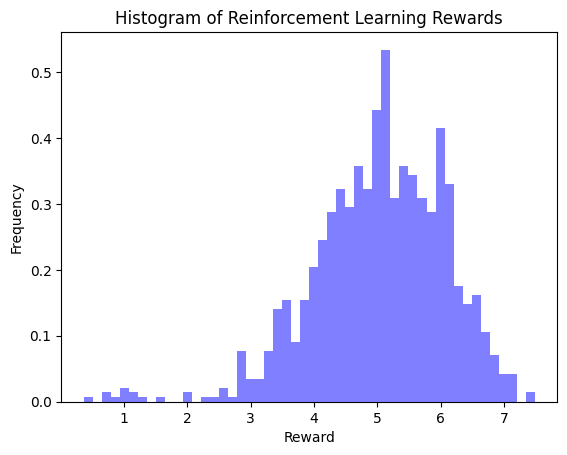

In [8]:
# Create a histogram
plt.hist([x*8 for x in rew], bins=50, density=True, alpha=0.5, color='blue')

# Add labels and title
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Reinforcement Learning Rewards')

# Show the plot
plt.show()

In [21]:
traj[0]

[(<[], [], []>, <GraphActionType.AddNode, 0, 11>),
 (<[0], [], [11]>, <GraphActionType.AddNode, 0, 41>),
 (<[0, 1], [(0, 1)], [11, 41]>, <GraphActionType.AddNode, 0, 7>),
 (<[0, 1, 2], [(0, 1), (0, 2)], [11, 41, 7]>,
  <GraphActionType.AddNode, 2, 67>),
 (<[0, 1, 2, 3], [(0, 1), (0, 2), (2, 3)], [11, 41, 7, 67]>,
  <GraphActionType.AddNode, 3, 59>),
 (<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (3, 4)], [11, 41, 7, 67, 59]>,
  <GraphActionType.AddNode, 2, 62>),
 (<[0, 1, 2, 3, 4, 5], [(0, 1), (0, 2), (2, 3), (2, 5), (3, 4)], [11, 41, 7, 67, 59, 62]>,
  <GraphActionType.SetEdgeAttr, 2, 5, dst_attach, 1>),
 (<[0, 1, 2, 3, 4, 5], [(0, 1), (0, 2), (2, 3), (2, 5), (3, 4)], [11, 41, 7, 67, 59, 62]>,
  <GraphActionType.AddNode, 5, 65>),
 (<[0, 1, 2, 3, 4, 5, 6], [(0, 1), (0, 2), (2, 3), (2, 5), (3, 4), (5, 6)], [11, 41, 7, 67, 59, 62, 65]>,
  <GraphActionType.AddNode, 4, 56>),
 (<[0, 1, 2, 3, 4, 5, 6, 7], [(0, 1), (0, 2), (2, 3), (2, 5), (3, 4), (4, 7), (5, 6)], [11, 41, 7, 67, 59, 62, 65, 56]

In [10]:
# How does a step of trajectory look like?
traj_id = 10
state = 4
print(traj[traj_id][state])
print(f"Current graph: {traj[traj_id][state][0]}")
cur_action = traj[traj_id][state][1]
print(f"Current action: {cur_action}")
print(f"Action source: {cur_action.source}")
print(f"Action target: {cur_action.target}")
print(f"Action value: {cur_action.value}")

(<[0, 1, 2, 3], [(0, 1), (1, 2), (2, 3)], [68, 7, 7, 9]>, <GraphActionType.AddNode, 0, 65>)
Current graph: <[0, 1, 2, 3], [(0, 1), (1, 2), (2, 3)], [68, 7, 7, 9]>
Current action: <GraphActionType.AddNode, 0, 65>
Action source: 0
Action target: None
Action value: 65


c1cn[nH]c1
C1CCCCC1
C1CCCCC1
C1CCNCC1
Next fragment added: c1ccccc1


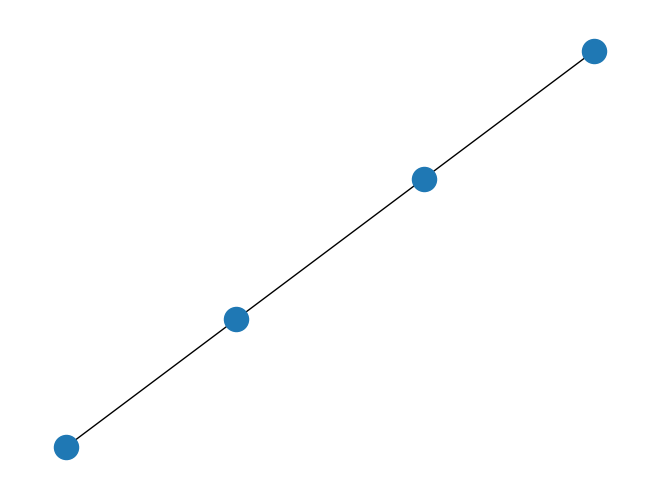

In [11]:
# How does nodes translate to fragments?
g = traj[traj_id][state][0]
for i in g.nodes:
    mol = trial.ctx.frags_mol[g.nodes[i]["v"]]
    mol_smi = trial.ctx.frags_smi[g.nodes[i]["v"]]
    print(mol_smi)
print(f"Next fragment added: {trial.ctx.frags_smi[cur_action.value]}")
nx.draw(g)

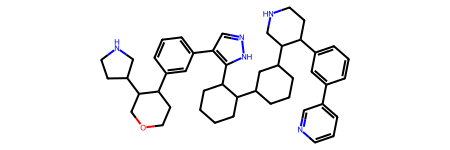

In [12]:
# Output molecule
trial.ctx.graph_to_mol(traj[traj_id][-1][0])

In [14]:
# Find min and max length of trajectories
min_len = 10**6
max_len = -1

for t in traj:
    l = len(t)
    if l>max_len:
        max_len = l
    if l<min_len:
        min_len = l
print(min_len)
print(max_len)

26
26


In [19]:
# Keep only actions from trajectories
actions = []

for t in traj:
    cur_act = []
    for step in t:
        cur_act.append(step[1])
    actions.append(cur_act)


In [31]:
actions[0]

[<GraphActionType.AddNode, 0, 11>,
 <GraphActionType.AddNode, 0, 41>,
 <GraphActionType.AddNode, 0, 7>,
 <GraphActionType.AddNode, 2, 67>,
 <GraphActionType.AddNode, 3, 59>,
 <GraphActionType.AddNode, 2, 62>,
 <GraphActionType.SetEdgeAttr, 2, 5, dst_attach, 1>,
 <GraphActionType.AddNode, 5, 65>,
 <GraphActionType.AddNode, 4, 56>,
 <GraphActionType.AddNode, 1, 9>,
 <GraphActionType.SetEdgeAttr, 2, 3, src_attach, 4>,
 <GraphActionType.SetEdgeAttr, 2, 5, src_attach, 0>,
 <GraphActionType.SetEdgeAttr, 5, 6, dst_attach, 5>,
 <GraphActionType.SetEdgeAttr, 0, 2, dst_attach, 2>,
 <GraphActionType.SetEdgeAttr, 0, 1, src_attach, 1>,
 <GraphActionType.SetEdgeAttr, 0, 1, dst_attach, 1>,
 <GraphActionType.SetEdgeAttr, 0, 2, src_attach, 0>,
 <GraphActionType.SetEdgeAttr, 4, 7, dst_attach, 1>,
 <GraphActionType.SetEdgeAttr, 4, 7, src_attach, 0>,
 <GraphActionType.SetEdgeAttr, 3, 4, src_attach, 1>,
 <GraphActionType.SetEdgeAttr, 1, 8, dst_attach, 1>,
 <GraphActionType.SetEdgeAttr, 2, 3, dst_attach, 0>

In [113]:
# Change actions representation
new_actions = []
for a in actions:
    new_act = []
    for s in a:
        new_s = []
        new_s.append(s.action.name)
        new_s.append(s.source)
        new_s.append(s.target)
        new_s.append(s.value)
        # new_s.append(s.attr)
        new_act.append(new_s)
    new_actions.append(new_act)

In [114]:
new_actions[0]

[['AddNode', 0, None, 11],
 ['AddNode', 0, None, 41],
 ['AddNode', 0, None, 7],
 ['AddNode', 2, None, 67],
 ['AddNode', 3, None, 59],
 ['AddNode', 2, None, 62],
 ['SetEdgeAttr', 2, 5, 1],
 ['AddNode', 5, None, 65],
 ['AddNode', 4, None, 56],
 ['AddNode', 1, None, 9],
 ['SetEdgeAttr', 2, 3, 4],
 ['SetEdgeAttr', 2, 5, 0],
 ['SetEdgeAttr', 5, 6, 5],
 ['SetEdgeAttr', 0, 2, 2],
 ['SetEdgeAttr', 0, 1, 1],
 ['SetEdgeAttr', 0, 1, 1],
 ['SetEdgeAttr', 0, 2, 0],
 ['SetEdgeAttr', 4, 7, 1],
 ['SetEdgeAttr', 4, 7, 0],
 ['SetEdgeAttr', 3, 4, 1],
 ['SetEdgeAttr', 1, 8, 1],
 ['SetEdgeAttr', 2, 3, 0],
 ['SetEdgeAttr', 5, 6, 0],
 ['SetEdgeAttr', 1, 8, 0],
 ['SetEdgeAttr', 3, 4, 1],
 ['Stop', None, None, None]]

In [115]:
# Numerical encoding
enc_dict = {}

action_names = set({})
action_attr = set({})

for a in new_actions:
    for s in a:
        action_names.add(s[0])
        # action_attr.add(str(s[-1]))

In [116]:
for idx, i in enumerate(action_names):
    enc_dict[i] = idx+1
# for idx, i in enumerate(action_attr):
#     enc_dict[i] = idx+1
enc_dict["None"] = -1

In [117]:
num_actions = []
for a in new_actions:
    new_a = []
    for s in a:
        new_s = []
        for i in s:
            if enc_dict.get(str(i)) is None:
                new_s.append(i)
            else:
                new_s.append(enc_dict[str(i)])
        new_a.append(new_s)
    num_actions.append(new_a)

In [118]:
num_actions[0]

[[3, 0, -1, 11],
 [3, 0, -1, 41],
 [3, 0, -1, 7],
 [3, 2, -1, 67],
 [3, 3, -1, 59],
 [3, 2, -1, 62],
 [2, 2, 5, 1],
 [3, 5, -1, 65],
 [3, 4, -1, 56],
 [3, 1, -1, 9],
 [2, 2, 3, 4],
 [2, 2, 5, 0],
 [2, 5, 6, 5],
 [2, 0, 2, 2],
 [2, 0, 1, 1],
 [2, 0, 1, 1],
 [2, 0, 2, 0],
 [2, 4, 7, 1],
 [2, 4, 7, 0],
 [2, 3, 4, 1],
 [2, 1, 8, 1],
 [2, 2, 3, 0],
 [2, 5, 6, 0],
 [2, 1, 8, 0],
 [2, 3, 4, 1],
 [1, -1, -1, -1]]

In [43]:
from keras import metrics
import keras
import tensorflow as tf
import os

In [136]:
def build_net(seq_len=26, feats=4):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', batch_input_shape=(None, seq_len, feats), return_sequences=True, name='encoder_1'))
    model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
    model.add(keras.layers.LSTM(8, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
    model.add(keras.layers.RepeatVector(seq_len, name='encoder_decoder_bridge'))
    model.add(keras.layers.LSTM(8, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
    model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
    model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
    model.compile(loss="mse",optimizer='adam')
    model.build()
    print(model.summary())
    return model


In [137]:
emb_nn = build_net()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 26, 32)            4736      
                                                                 
 encoder_2 (LSTM)            (None, 26, 16)            3136      
                                                                 
 encoder_3 (LSTM)            (None, 8)                 800       
                                                                 
 encoder_decoder_bridge (Re  (None, 26, 8)             0         
 peatVector)                                                     
                                                                 
 decoder_1 (LSTM)            (None, 26, 8)             544       
                                                                 
 decoder_2 (LSTM)            (None, 26, 16)            1600      
                                                      

In [138]:
X, X_val = num_actions[:750], num_actions[750:]

In [139]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

epochs = 500
batch_size = 64
emb_nn.fit(x=X, y=X, validation_data=(X_val, X_val), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stop])


Epoch 1/500
12/12 [==============================] - 14s 245ms/step - loss: 120.0639 - val_loss: 116.6020
Epoch 2/500
12/12 [==============================] - 0s 36ms/step - loss: 114.9991 - val_loss: 112.2036
Epoch 3/500
12/12 [==============================] - 0s 34ms/step - loss: 110.6942 - val_loss: 107.8773
Epoch 4/500
12/12 [==============================] - 0s 32ms/step - loss: 106.2692 - val_loss: 103.4053
Epoch 5/500
12/12 [==============================] - 0s 34ms/step - loss: 101.8271 - val_loss: 99.0243
Epoch 6/500
12/12 [==============================] - 0s 33ms/step - loss: 97.5042 - val_loss: 94.8051
Epoch 7/500
12/12 [==============================] - 0s 35ms/step - loss: 93.5561 - val_loss: 91.2964
Epoch 8/500
12/12 [==============================] - 0s 32ms/step - loss: 90.3858 - val_loss: 88.5762
Epoch 9/500
12/12 [==============================] - 0s 21ms/step - loss: 87.8660 - val_loss: 86.2642
Epoch 10/500
12/12 [==============================] - 0s 23ms/step - lo

In [130]:
from keras.models import Model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [140]:
encoder = Model(emb_nn.input, emb_nn.layers[2].output)

In [141]:
embeddings = encoder.predict(num_actions)

32/32 [==============================] - 1s 4ms/step


In [142]:
enb_reduce = TSNE(n_components=2).fit_transform(embeddings)

In [143]:
def plt_reduce_space(x, color=rew):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(8, 8))
    plt.scatter(x[:, 0], x[:, 1], c=color, cmap='coolwarm')
    plt.show()

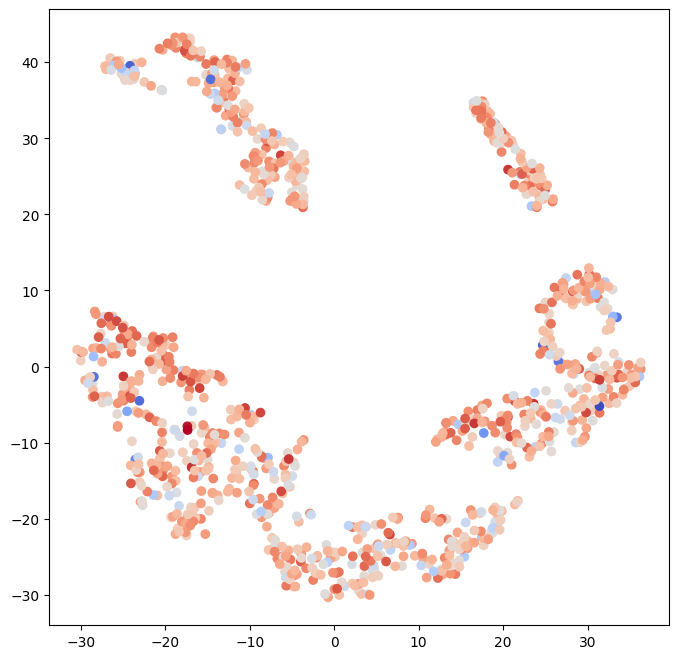

In [144]:
plt_reduce_space(enb_reduce)